<a href="https://colab.research.google.com/github/HazemmoAlsady/AWN_Graduation_Project/blob/main/ocr_finetune_vlm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pdf2image==1.17.0 pillow==12.1.0 tqdm
!apt-get install -y poppler-utils
!pip install json-repair

In [ ]:
!pip install litellm==1.73.6

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from google.colab import userdata
hf_token = userdata.get('huggingface')

!huggingface-cli login --token {hf_token}

## Start

In [ ]:
import os
from os.path import join
import random
from tqdm.auto import tqdm
import json
import json_repair

from glob import glob
from pdf2image import convert_from_path
from PIL import Image
from PIL import ImageEnhance
from IPython.display import Image as IPImage, display

from google.colab import userdata
import litellm
from litellm import completion

openrouter_token = userdata.get('openrouter')

os.environ["OPENAI_API_KEY"] = openrouter_token
os.environ['OPENAI_BASE_URL'] = "https://openrouter.ai/api/v1"

data_dir = "/gdrive/MyDrive/youtube-resources/temp/image-ocr-finetune/assets"

def parse_json(text):
    try:
        return json_repair.loads(text)
    except:
        return None

In [ ]:
import base64

def image_to_base64_data_uri(image_path):

    """Convert image to base64 data URI for APIs"""
    with open(image_path, 'rb') as image_file:
        img_base64 = base64.b64encode(image_file.read()).decode('utf-8')

    # Determine image type from extension
    ext = image_path.lower().split('.')[-1]
    mime_type = f"image/{ext}" if ext != "jpg" else "image/jpeg"

    return f"data:{mime_type};base64,{img_base64}"



prompt = """
# Document Analysis & Extraction Prompt

## Task
Extract structured data from document images and return as valid JSON. Use exact enumeration values provided. Extract text in its ORIGINAL SCRIPT - never transliterate or translate names, titles, or any text unless the original is in that script.

## Output Format

```json
{
  "document_classification": {
    "type": "enum: official_letter | decree | regulation | statistical_report | table_of_contents | administrative_decision | legal_amendment | memo | certificate | form | invoice | contract | court_ruling | minutes | circular | announcement | report | other",
    "subtype": "string or null",
    "category": "enum: legal | administrative | financial | statistical | correspondence | technical | hr | other",
    "primary_language": "enum: arabic | english | french | mixed | other",
    "secondary_languages": ["array of language codes if multilingual"]
  },

  "source": {
    "issuing_authority": "string: full organization name in ORIGINAL SCRIPT",
    "department": "string or null: specific division/unit in ORIGINAL SCRIPT",
    "location": "string or null: city/region",
    "document_number": "string or null: official reference number EXACTLY as shown",
    "related_references": ["array: all other document numbers mentioned anywhere in document"],
    "dates": {
      "primary_date": {
        "date_text": "string: main document date EXACTLY as written",
        "calendar_type": "enum: hijri | gregorian | unknown",
        "date_type": "enum: issue_date | effective_date | received_date | other",
        "indicators": "string: calendar markers like 'هـ' or 'م'",
        "location_in_document": "enum: header | body | footer | stamp | other"
      },
      "additional_dates": [
        {
          "date_text": "string: EXACTLY as written",
          "calendar_type": "enum: hijri | gregorian | unknown",
          "date_type": "enum: reference_date | deadline | expiry_date | effective_date | other",
          "context": "string: brief context of where/why this date appears",
          "indicators": "string or null"
        }
      ]
    }
  },

  "physical_properties": {
    "page_number": "string: e.g., '7', '7/254', 'single', 'unknown'",
    "total_pages": "integer or null",
    "image_type": "enum: digital | scanned | photographed | mixed | unknown",
    "quality": "enum: high | medium | low | illegible",
    "color_mode": "enum: color | grayscale | black_white | mixed",
    "has_watermark": "boolean",
    "watermark_description": "string or null",
    "has_security_pattern": "boolean",
    "security_pattern_description": "string or null",
    "orientation": "enum: portrait | landscape"
  },

  "official_marks": {
    "seals": [
      {
        "organization": "string: in ORIGINAL SCRIPT",
        "position": "enum: header | footer | center | top_right | top_left | bottom_right | bottom_left | margin | overlapping_text | other",
        "description": "string: detailed visual description",
        "is_digital": "boolean",
        "shape": "enum: circular | oval | rectangular | square | irregular | other"
      }
    ],
    "stamps": [
      {
        "type": "enum: approval | received | confidential | urgent | date_stamp | routing | registry | copy | original | other",
        "text_content": "string: ALL text on stamp in ORIGINAL SCRIPT",
        "color": "enum: red | blue | black | green | purple | brown | other",
        "position": "enum: header | footer | center | top_right | top_left | bottom_right | bottom_left | margin | overlapping_text | other",
        "is_digital": "boolean",
        "shape": "enum: circular | rectangular | square | oval | irregular"
      }
    ],
    "barcodes_qr": [
      {
        "type": "enum: barcode | qr_code | data_matrix | other",
        "position": "string",
        "readable_data": "string or null"
      }
    ]
  },

  "signatures_authorization": {
    "signatories": [
      {
        "name": "string: EXACTLY as written in ORIGINAL SCRIPT (Arabic/English/etc)",
        "name_transliteration": "string or null: only if BOTH scripts appear in document",
        "title": "string: official position in ORIGINAL SCRIPT",
        "signature_type": "enum: handwritten | digital | stamp | printed_name | not_present",
        "position": "enum: bottom_left | bottom_right | bottom_center | top_right | top_left | middle_right | middle_left | end_of_document | other",
        "role": "enum: primary_signatory | co_signatory | witness | approver | preparer | reviewer | other"
      }
    ],
    "approval_chain": [
      {
        "step": "integer: order in chain (1, 2, 3...)",
        "role": "enum: prepared_by | reviewed_by | approved_by | authorized_by | noted_by | verified_by | other",
        "name": "string or null: in ORIGINAL SCRIPT",
        "title": "string or null: in ORIGINAL SCRIPT",
        "date": "string or null"
      }
    ]
  },

  "routing_distribution": {
    "addressed_to": [
      {
        "type": "enum: person | department | organization | position | general",
        "name": "string: in ORIGINAL SCRIPT",
        "honorific": "string or null: titles like 'فضيلة', 'سعادة', 'معالي'"
      }
    ],
    "carbon_copy": [
      {
        "type": "enum: person | department | organization | position",
        "name": "string: in ORIGINAL SCRIPT"
      }
    ],
    "forwarded_to": [
      {
        "type": "enum: person | department | organization | position",
        "name": "string: in ORIGINAL SCRIPT",
        "date": "string or null"
      }
    ],
    "file_reference": "string or null: internal filing/tracking code",
    "classification": "string or null: security/filing classification in ORIGINAL SCRIPT"
  },

  "content": {
    "subject": "string: document subject/title in ORIGINAL SCRIPT",
    "subject_translation": "string or null: only if explicitly needed",
    "keywords": ["array: 5-10 keywords in ORIGINAL SCRIPT"],
    "full_text": "string: complete text extraction with line breaks, in ORIGINAL SCRIPT",
    "has_tables": "boolean",
    "tables": [
      {
        "title": "string or null: in ORIGINAL SCRIPT",
        "headers": ["array: column headers in ORIGINAL SCRIPT"],
        "rows": [
          ["array of cell values per row in ORIGINAL SCRIPT"]
        ],
        "notes": "string or null"
      }
    ],
    "has_lists": "boolean",
    "lists": [
      {
        "type": "enum: numbered | bulleted | lettered | arabic_numbered | hierarchical",
        "items": ["array: items in ORIGINAL SCRIPT with hierarchy preserved"]
      }
    ],
    "has_charts": "boolean",
    "charts": [
      {
        "type": "enum: bar | line | pie | area | scatter | table | mixed | other",
        "title": "string or null: chart title in ORIGINAL SCRIPT",
        "description": "string: brief description of what chart displays",
        "data": [
          {
            "label": "string: category/bar/data point label in ORIGINAL SCRIPT",
            "value": "number or string: numerical value EXACTLY as shown",
            "position": "integer: order/sequence (1, 2, 3...)"
          }
        ],
        "axis_info": {
          "x_axis_label": "string or null: in ORIGINAL SCRIPT",
          "y_axis_label": "string or null: in ORIGINAL SCRIPT",
          "x_axis_type": "enum: categorical | numerical | date | other",
          "y_axis_type": "enum: categorical | numerical | percentage | other"
        },
        "notes": "string or null: any footnotes or additional chart info"
      }
    ],
    "legal_articles": [
      {
        "article_number": "string: in ORIGINAL SCRIPT e.g., 'المادة الأولى', 'Article 1'",
        "article_title": "string or null: in ORIGINAL SCRIPT",
        "content": "string: full article text in ORIGINAL SCRIPT"
      }
    ],
    "financial_data": [
      {
        "description": "string: in ORIGINAL SCRIPT",
        "amount": "string: numerical value EXACTLY as shown",
        "currency": "string: SAR, USD, etc. or in ORIGINAL SCRIPT"
      }
    ]
  },

  "structural_elements": {
    "header": {
      "present": "boolean",
      "content": "string or null: ALL header text in ORIGINAL SCRIPT",
      "has_logo": "boolean",
      "logo_description": "string or null",
      "reference_numbers": ["array: any reference numbers in header"]
    },
    "footer": {
      "present": "boolean",
      "content": "string or null: ALL footer text in ORIGINAL SCRIPT",
      "has_page_number": "boolean",
      "page_info": "string or null: page numbering format"
    },
    "letterhead": {
      "present": "boolean",
      "organization_name": "string or null: in ORIGINAL SCRIPT",
      "organization_name_secondary": "string or null: if in another language",
      "emblem_description": "string or null",
      "contact_info": "string or null: addresses, phones, emails, websites"
    },
    "margins_notes": {
      "has_margin_notes": "boolean",
      "margin_content": "string or null: any handwritten or printed margin notes in ORIGINAL SCRIPT"
    }
  },

  "attachments_references": {
    "attachments_mentioned": [
      {
        "description": "string: in ORIGINAL SCRIPT",
        "count": "integer or null",
        "reference_number": "string or null"
      }
    ],
    "referenced_documents": [
      {
        "type": "enum: law | regulation | decree | previous_decision | letter | circular | report | contract | minutes | other",
        "reference": "string: document identifier in ORIGINAL SCRIPT",
        "date": "string or null: if date is mentioned for this reference"
      }
    ]
  },

  "condition_notes": {
    "completeness": "enum: complete | partial | missing_pages | fragment | unknown",
    "legibility_issues": ["array: describe sections with poor legibility"],
    "physical_damage": "enum: none | minor | moderate | severe | not_applicable",
    "damage_description": "string or null",
    "handwritten_annotations": {
      "present": "boolean",
      "description": "string or null: describe notes, highlights, corrections"
    },
    "special_observations": "string or null"
  },

  "confidence_quality": {
    "overall_confidence": "enum: high | medium | low",
    "uncertain_elements": ["array: list specific elements with low confidence"],
    "requires_manual_review": "boolean",
    "review_reasons": ["array: specific areas needing verification"]
  }
}
```

## Critical Extraction Rules

### 1. ORIGINAL SCRIPT REQUIREMENT ⚠️
**MOST IMPORTANT**: Extract ALL text in its original script/language:
- Arabic names stay in Arabic: سلمان بن فوزان الفوزان (NOT "Salman bin Fawzan Al-Fawzan")
- Arabic titles stay in Arabic: القائم بعمل نائب وزير العدل (NOT translated)
- Do NOT romanize, transliterate, or translate unless the document itself shows both versions
- Preserve all diacritics and special characters exactly

### 2. Date Extraction Structure
**PRIMARY vs ADDITIONAL dates**:
- **primary_date**: The main document date (usually in header: "التاريخ")
- **additional_dates**: All other dates referenced in the body (from previous documents, deadlines, references)
- NEVER mix these - the primary date must be clearly identified
- Extract the date position: header dates are usually primary/issue dates

### 3. Name and Title Extraction
When extracting signatories or addressed persons:
```json
{
  "name": "سلمان بن فوزان الفوزان",  // ORIGINAL SCRIPT
  "title": "القائم بعمل نائب وزير العدل"  // ORIGINAL SCRIPT
}
```
NOT:
```json
{
  "name": "Salman bin Fawzan Al-Fawzan",  // WRONG - transliterated
  "title": "Acting Deputy Minister of Justice"  // WRONG - translated
}
```

### 4. Document Numbers
Extract EXACTLY as shown, preserving:
- All numbers and separators: "13/ت/8795" not "13-8795"
- Arabic and Latin characters: "م/38" not "M/38"
- Parentheses and formatting: "(م/38)" not "م/38"

### 5. Reference Numbers vs Content References
- **document_number**: The THIS document's official number (in header)
- **related_references**: OTHER document numbers mentioned in text body
- **file_reference**: Internal tracking/filing number (often in footer)

### 6. Stamps and Seals - Key Differences
**Seals** (الختم):
- Usually embossed or official emblems
- Circular/oval shapes with organization logo
- May be digital or physical
- Example: Ministry emblem at top

**Stamps** (الطابع):
- Ink impressions with text
- Rectangular/square more common
- Date stamps, approval stamps, "صورة" stamps
- Usually red, blue, or black ink

### 7. Honorifics in Routing
Capture separately:
```json
{
  "type": "position",
  "name": "نائب وزير العدل",
  "honorific": "فضيلة"
}
```
Common honorifics: فضيلة، سعادة، معالي، صاحب السمو

### 8. Header Components
Extract ALL elements from header:
- Organization name (right side usually)
- Department name
- Document number ("الرقم")
- Date ("التاريخ")
- Attachments line ("المرفقات")
- Subject line ("الموضوع")
- Reference number boxes (e.g., [277])

### 9. Chart and Graph Data Extraction
**CRITICAL**: Extract actual data values, not summaries:

For **Bar Charts**:
- Each bar = one data object with label + value
- Extract values from bars (read the number labels)
- Maintain order left-to-right or as shown
- Example for chart with 3 bars:
```json
"data": [
  {"label": "التعديلات", "value": 33, "position": 1},
  {"label": "المواد الملغية", "value": 51, "position": 2},
  {"label": "المواد والفقرات المضافة", "value": 25, "position": 3}
]
```

For **Line Charts**:
- Each point = one data object
- Extract x and y values
- Maintain sequence

For **Pie Charts**:
- Each slice = one data object with label + value/percentage

**DO NOT** create a text summary like "التعديلات: 33, المواد الملغية: 51" ❌
**DO** extract structured data array with each value as separate object ✓

Read numbers directly from:
- Value labels on/above bars
- Data point labels
- Axis tick marks
- Legend entries with values

### 10. Table Data Extraction
For tables, extract into structured format:
```json
"tables": [
  {
    "title": "عنوان الجدول",
    "headers": ["العمود الأول", "العمود الثاني", "العمود الثالث"],
    "rows": [
      ["قيمة 1-1", "قيمة 1-2", "قيمة 1-3"],
      ["قيمة 2-1", "قيمة 2-2", "قيمة 2-3"]
    ],
    "notes": "any table footnotes",
    "row_count": 2,
    "column_count": 3
  }
]
```

**Table Recognition**:
- Look for grid lines (horizontal/vertical)
- Header row usually bold or separated
- Aligned columns of data
- May have borders or just spacing

### 11. Full Text Requirements
In `full_text` field:
- Include ALL visible text
- Preserve line breaks with \n
- Keep original structure (indentation where meaningful)
- Include header, body, footer, and signatures
- Do NOT translate anything
- Include text from stamps if legible
- Include chart titles and labels (but data goes in charts section)

### 12. Referenced Documents
When document mentions other documents:
```json
{
  "type": "circular",
  "reference": "تعميم الوزارة رقم 13/ت/1839",
  "date": "12/8/1422هـ"
}
```
Extract: document type, full reference including number, and date if mentioned

## Chart and Table Extraction Examples

### Example 1: Bar Chart
For a bar chart showing three categories with values:
```json
{
  "type": "bar",
  "title": "(أ) التعديلات على النظام واللائحة",
  "description": "Bar chart showing amendments, repealed articles, and added articles",
  "data": [
    {"label": "التعديلات", "value": 33, "position": 1},
    {"label": "المواد الملغية", "value": 51, "position": 2},
    {"label": "المواد والفقرات المضافة", "value": 25, "position": 3}
  ],
  "axis_info": {
    "x_axis_label": null,
    "y_axis_label": null,
    "x_axis_type": "categorical",
    "y_axis_type": "numerical"
  },
  "notes": null
}
```

### Example 2: Multi-Category Bar Chart
For a chart with 7 different categories:
```json
{
  "type": "bar",
  "title": "(ب) المرفقات والملحقات",
  "description": "Bar chart showing counts of various legal documents and references",
  "data": [
    {"label": "لوائح متعلقة بالنظام", "value": 3, "position": 1},
    {"label": "الأحكام القضائية", "value": 98, "position": 2},
    {"label": "قرارات وتعاميم وزارة العدل", "value": 16, "position": 3},
    {"label": "تعاميم المجلس الأعلى للقضاء", "value": 32, "position": 4},
    {"label": "قرارات مجلس الوزراء ومجلس الشورى", "value": 4, "position": 5},
    {"label": "المراسيم الملكية", "value": 23, "position": 6},
    {"label": "الأوامر الملكية", "value": 4, "position": 7}
  ],
  "axis_info": {
    "x_axis_label": null,
    "y_axis_label": null,
    "x_axis_type": "categorical",
    "y_axis_type": "numerical"
  },
  "notes": null
}
```

### Example 3: Table Data
```json
{
  "title": "جدول المقارنة",
  "headers": ["البند", "العدد", "النسبة"],
  "rows": [
    ["التعديلات", "33", "30%"],
    ["المواد الملغية", "51", "46%"],
    ["المضافة", "25", "24%"]
  ],
  "notes": null,
  "row_count": 3,
  "column_count": 3
}
```

## Common Mistakes to Avoid

❌ **WRONG - Text summary instead of structured data**:
```json
"data_summary": "التعديلات: 33, المواد الملغية: 51, المواد والفقرات المضافة: 25"
```

✅ **CORRECT - Structured data array**:
```json
"data": [
  {"label": "التعديلات", "value": 33, "position": 1},
  {"label": "المواد الملغية", "value": 51, "position": 2},
  {"label": "المواد والفقرات المضافة", "value": 25, "position": 3}
]
```

❌ **WRONG - Missing values**:
```json
"axis_labels": ["التعديلات", "المواد الملغية", "المواد والفقرات المضافة"]
```

✅ **CORRECT - Labels with values**:
```json
"data": [
  {"label": "التعديلات", "value": 33, "position": 1},
  ...
]
```

❌ **WRONG - Translating labels**:
```json
{"label": "Amendments", "value": 33}
```

✅ **CORRECT - Original script**:
```json
{"label": "التعديلات", "value": 33}
```

### Saudi Official Letter/Circular Header:
```
[Logo]  المملكة العربية السعودية
        وزارة [الوزارة]
[###]   [إدارة]

الرقم: [number]         التاريخ: [date]
المرفقات: ______       الموضوع: [subject]
```

### Signature Block:
```
[Title line in Arabic]
[Handwritten signature]
[Printed name in Arabic]
```

### Footer Elements:
- Classification: "التصنيف:"
- Copy notation: "صورة لـ"
- File reference: "القيد رقم"
- Print date: "طبع في"
- Form number: "نموذج"

## Date Indicators Reference
- **هـ** or **ه** = Hijri calendar
- **م** = Gregorian (Miladi) calendar
- Format variations: ١٤٤٣/٩/١٣ or 1443/9/13 or ١٣-٩-١٤٤٣هـ
- Context: "التاريخ" means "Date", "بتاريخ" means "dated"

## Validation Checklist
Before returning JSON:
- [ ] All Arabic text kept in Arabic (not romanized)
- [ ] Primary document date separated from reference dates
- [ ] Document number vs file reference separated
- [ ] Names and titles in original script
- [ ] All enum values match specified options exactly
- [ ] No null in array fields (use empty array [])
- [ ] Valid JSON syntax (test with JSON parser)
- [ ] full_text includes all visible text
- [ ] Stamps vs seals correctly categorized

## Output Instructions
Return ONLY the JSON object. No markdown code blocks, no explanatory text. Start directly with `{` and end with `}`.
""".strip()

## Pdf to Images

In [ ]:
def preprocess_image(image, max_width=600):
    """
    Preprocess image to reduce size and prepare for OCR.

    Args:
        image: PIL Image object
        max_width: Maximum width in pixels (height auto-calculated to maintain ratio)

    Steps:
    1. Convert to grayscale (reduces size and improves OCR)
    2. Resize to reasonable width while maintaining aspect ratio
    3. Increase contrast
    """

    # Convert to grayscale
    gray_image = image.convert('L')

    # Resize if image is too large
    if gray_image.width > max_width:
        # Calculate new height to maintain aspect ratio
        ratio = max_width / gray_image.width
        new_height = int(gray_image.height * ratio)
        gray_image = gray_image.resize((max_width, new_height), Image.LANCZOS)

    enhancer = ImageEnhance.Contrast(gray_image)
    enhanced_image = enhancer.enhance(1.5)

    return enhanced_image


def convert_pdf_to_images(pdf_path, output_base_dir, max_width=600):
    """
    Convert a PDF file to a set of preprocessed images.

    Args:
        pdf_path: Path to the PDF file
        output_base_dir: Base directory to save images
        max_width: Maximum width for output images (default: 600px)
    """

    # Get PDF filename without extension
    pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]

    # Create output directory for this PDF
    output_dir = join(output_base_dir, pdf_name)
    os.makedirs(output_dir, exist_ok=True)

    print(f"Converting {pdf_name}.pdf...")

    images = convert_from_path(pdf_path, dpi=200)
    generated_paths = []

    # Process and save each page
    for page_num, image in enumerate(images, start=1):

        # Preprocess the image
        processed_image = preprocess_image(image, max_width)

        # Save as JPEG with optimization
        output_path = join(output_dir, f"page_{page_num:03d}.jpg")
        processed_image.save(output_path, 'JPEG', quality=85, optimize=True)

        print(f"  Saved page {page_num} -> {output_path}")
        generated_paths.append(output_path)

    return generated_paths


In [ ]:
output_dir = f"{data_dir}/pdf_images"
pdf_files = glob(f"{data_dir}/downloaded_pdfs/*.pdf")
max_width = 600

for pdf_file in tqdm(pdf_files):

    _ = convert_pdf_to_images(
        pdf_file,
        output_dir,
        max_width
    )

## Evaluate Base Model



In [ ]:
from transformers import AutoProcessor, Gemma3ForConditionalGeneration
from PIL import Image
import torch

model_id = "google/gemma-3-4b-it"

sample_image_path = f"{data_dir}/pdf_images/0001/page_006.jpg"


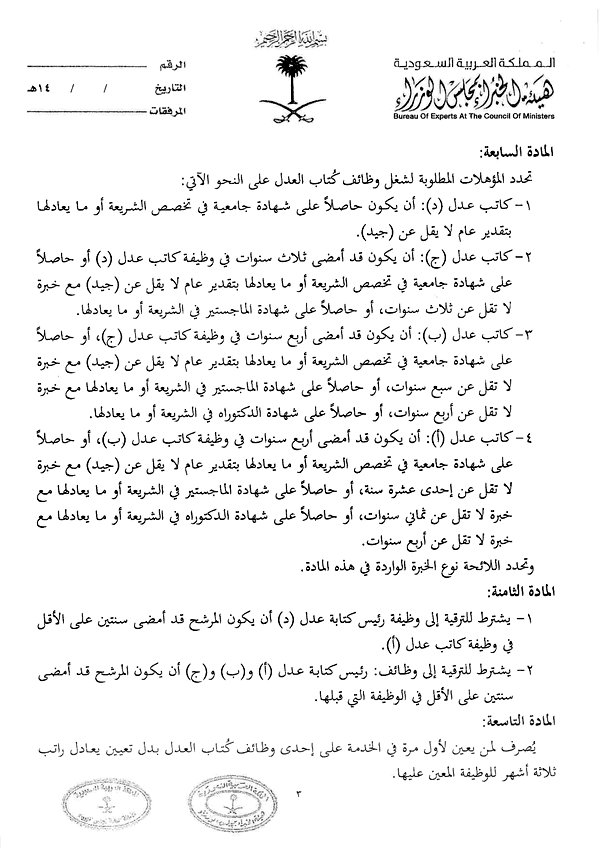

In [ ]:
display(IPImage(filename=sample_image_path))

In [ ]:
model = Gemma3ForConditionalGeneration.from_pretrained(
    model_id,
    dtype="auto", device_map="auto"
).eval()

processor = AutoProcessor.from_pretrained(model_id)

In [ ]:
# prompt = """
# Act as an OCR Model. Extract the exact details of the image into a markdown format.

# ## Outout:
# ```markdown
# """.strip()

messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a helpful assistant."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "image": sample_image_path},
            {"type": "text", "text": prompt}
        ]
    }
]

inputs = processor.apply_chat_template(
    messages,

    add_generation_prompt=True, tokenize=True,
    return_dict=True, return_tensors="pt"
).to(model.device)


input_len = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=1024, do_sample=False)
    generation = generation[0][input_len:]

decoded = processor.decode(generation, skip_special_tokens=True)

print(decoded)

## Evalute Gemini3 Model

In [ ]:
cloud_model_id = "openai/google/gemini-3-flash-preview"
sample_image_path = f"{data_dir}/pdf_images/0001/page_006.jpg"

In [ ]:
messages=[
    {
        "role": "user",
        "content": [
            {"type": "text", "text": prompt},
            {
                "type": "image_url",
                "image_url": {
                    "url": image_to_base64_data_uri(sample_image_path)
                }
            }

        ]
    }
]

response = completion(
    model=cloud_model_id,
    messages=messages,
    max_tokens=4096
)

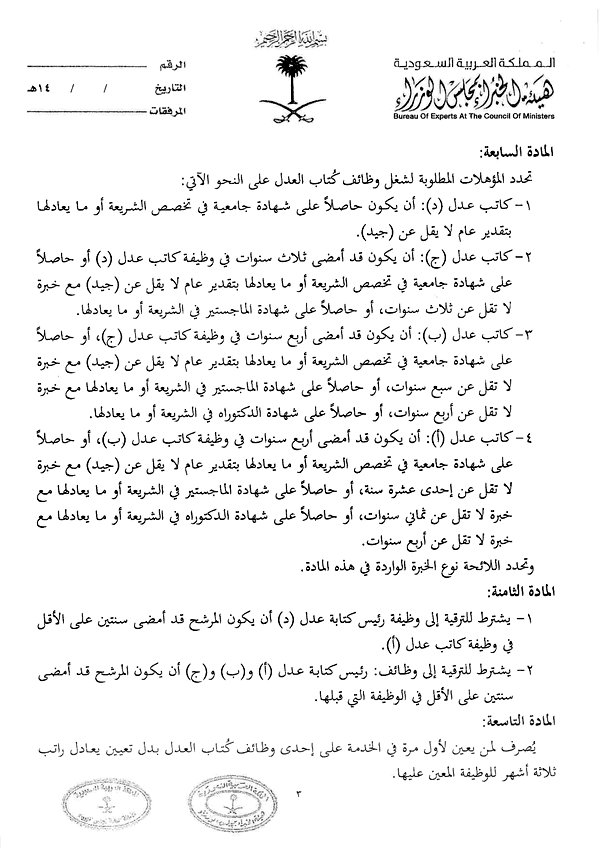

In [ ]:
display(IPImage(filename=sample_image_path))

In [ ]:
print(response.choices[0].message.content)

## Knowledge Distillation

In [ ]:
output_dir = f"{data_dir}/pdf_images"
pdf_files = glob(f"{data_dir}/downloaded_pdfs/*.pdf")

pdf_images_paths = {}

for pdf_file in pdf_files:
    pdf_name = os.path.basename(pdf_file)
    pdf_images = glob(join(output_dir, pdf_name, "*.jpg"))

    pdf_images_paths[pdf_name] = pdf_images

In [ ]:
cloud_model_id = "openai/google/gemini-3-flash-preview"
output_sft_file = join(data_dir, "ocr-image-sft.jsonl")

price_per_1m_input_tokens = 0.5
price_per_1m_output_tokens = 3.0

prompt_tokens = 0
completion_tokens = 0

ix = 0

for pdf_name, images in pdf_images_paths.items():

    for img in tqdm(images, desc=f"file_{pdf_name}"):

        ix += 1

        # if ix < 500:
        #     continue

        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": image_to_base64_data_uri(img)
                        }
                    }

                ]
            }
        ]

        response = completion(
            model=cloud_model_id,
            messages=messages,
            max_tokens=8000
        )

        if response.choices[0].finish_reason != 'stop':
            print(f"Error Stop: {ix}", response.choices[0].finish_reason)
            continue

        llm_response = response.choices[0].message.content

        with open(output_sft_file, "a", encoding="utf8") as dest:

            dest.write(json.dumps(
                {
                    "id": ix,
                    "pdf_name": pdf_name,
                    "image_path": img,
                    "model_id": cloud_model_id,
                    "output": llm_response,
                },
                default=str, ensure_ascii=False,
            ) + "\n")

        prompt_tokens += response.usage.prompt_tokens
        completion_tokens += response.usage.completion_tokens

        if (ix % 3) == 0:
            cost_input = (prompt_tokens / 1_000_000) * price_per_1m_input_tokens
            cost_output = (completion_tokens / 1_000_000) * price_per_1m_output_tokens
            total_cost = cost_input + cost_output

            print(f"Iteration {ix}: Total Cost = ${total_cost:.4f} ")


In [ ]:
# Iteration 2058: Total Cost = $19.0006

## Format Dataset for Finetuning

In [ ]:
output_dir = f"{data_dir}/pdf_images"
output_sft_file = join(data_dir, "ocr-image-sft.jsonl")

In [ ]:
for line in open(output_sft_file):

    rec = json.loads(line.strip())

    break

In [ ]:
llm_finetunning_data = []

task_1_message = """
You are a professional OCR Details Extractor.
Your rule to extract: the page markdown content in addition to the structural_elements of the document.
Extract the final output into a json format.
Do not generate any introduction or conclusion.
""".strip()

task_2_message = """
You are a professional OCR Details Extractor.
Your rule to extract the: document_classification, source, physical_properties, official_marks, signatures_authorization, routing_distribution, attachments_references, condition_notes and confidence_quality of the document.
Extract the final output into a json format.
Do not generate any introduction or conclusion.
""".strip()

val_pdf_files = ['0012.pdf', '0005.pdf', '0011.pdf']

train_ds = []
val_ds = []

image_paths_set = set()

for line in open(output_sft_file):

    if line.strip() == "":
        continue

    rec = json.loads(line.strip())
    pdf_name = rec['pdf_name']

    llm_output = parse_json(rec['output'])
    if not llm_output:
        continue

    if rec['image_path'] in image_paths_set:
        continue

    image_paths_set.add(rec['image_path'])

    task_1_output = {
        'content': llm_output['content'],
        'structural_elements': llm_output.get("structural_elements", ""),
    }

    del llm_output['content']

    if 'structural_elements' in llm_output:
        del llm_output['structural_elements']

    task_2_output = llm_output

    task_1_sft_recored = {
        "conversations": [
                {
                    "value": "<image>"+task_1_message,
                    "from": "human"
                },
                {
                    "value": json.dumps(
                        task_1_output,
                        ensure_ascii=False, default=str
                    ),
                    "from": "gpt"
                }
            ],
        "images": [
            rec['image_path']
        ]
    }

    task_2_sft_recored = {
        "conversations": [
                {
                    "value": "<image>"+task_2_message,
                    "from": "human"
                },
                {
                    "value": json.dumps(
                        task_2_output,
                        ensure_ascii=False, default=str
                    ),
                    "from": "gpt"
                }
            ],
        "images": [
            rec['image_path']
        ]
    }

    if pdf_name in val_pdf_files:
        val_ds.append(task_1_sft_recored)
        val_ds.append(task_2_sft_recored)
    else:
        train_ds.append(task_1_sft_recored)
        train_ds.append(task_2_sft_recored)


random.Random(101).shuffle(val_ds)
random.Random(101).shuffle(train_ds)


In [ ]:
rec['image_path']

'/gdrive/MyDrive/youtube-resources/temp/image-ocr-finetune/assets/pdf_images/0071/page_011.jpg'

In [ ]:
!zip -r /gdrive/MyDrive/youtube-resources/temp/image-ocr-finetune/assets/ocr-images-v1.zip \
   /gdrive/MyDrive/youtube-resources/temp/image-ocr-finetune/assets/pdf_images/

In [ ]:
os.makedirs(
    join(data_dir, "datasets", "llamafactory-ocr-finetune-data"), exist_ok=True
)

with open(join(data_dir, "datasets", "llamafactory-ocr-finetune-data", "train-v1.json") , "w") as dest:
    json.dump(train_ds, dest, ensure_ascii=False, default=str)

with open(join(data_dir, "datasets", "llamafactory-ocr-finetune-data", "val-v1.json") , "w") as dest:
    json.dump(val_ds, dest, ensure_ascii=False, default=str)

In [ ]:
join(data_dir, "datasets", "llamafactory-ocr-finetune-data", "train-v1.json")

'/gdrive/MyDrive/youtube-resources/temp/image-ocr-finetune/assets/datasets/llamafactory-ocr-finetune-data/train-v1.json'

## Migrate to Cloud GPU

### Doownload Dataset from Google Drive

In [ ]:
!pip install gdown

In [ ]:
import gdown

pdf_images_file_id = "1lEIBTelue5oZ58hOf8uzAV7cQlwTFK7R"
gdown.download(id=pdf_images_file_id, output="./pdf_images.zip")


train_file_id = "1_uvcHaIj6Qr_S6ITSWQ6UF9_gnxZ4cNh"
gdown.download(id=train_file_id, output="./train-v1.json")


val_file_id = "1Mxo5uvEotNQYhxzAipDdP-zUCYkw8GwB"
gdown.download(id=val_file_id, output="./val-v1.json")

### Fix Images Paths

In [ ]:
import json

with open("./train-v1.json") as src:
    train_ds = json.loads(src.read())

with open("./val-v1.json") as src:
    val_ds = json.loads(src.read())

for i in range(len(train_ds)):
    train_ds[i]['images'][0] = train_ds[i]['images'][0].replace(
        "/gdrive/MyDrive/youtube-resources/temp/image-ocr-finetune/assets/pdf_images/",
        "/workspace/pdf_images/"
    )

for i in range(len(val_ds)):
    val_ds[i]['images'][0] = val_ds[i]['images'][0].replace(
        "/gdrive/MyDrive/youtube-resources/temp/image-ocr-finetune/assets/pdf_images/",
        "/workspace/pdf_images/"
    )

In [ ]:
with open("./train-v1-edited.json" , "w") as dest:
    json.dump(train_ds, dest, ensure_ascii=False, default=str)

with open("./val-v1-edited.json" , "w") as dest:
    json.dump(val_ds, dest, ensure_ascii=False, default=str)

## Finetune

### Installation

In [ ]:
!pip install transformers==4.57.6
!pip install optimum==1.26.0
!pip install datasets==4.4.0

!pip install torch==2.8.0
!pip install torchvision==0.23
!pip install torchaudio==2.8.0

!git clone --depth 1 https://github.com/hiyouga/LlamaFactory.git
!cd LlamaFactory && git checkout 762b480131908d37736ad9aa3f12e87f8f7e6313

!cd LlamaFactory && pip install -e .
!cd LlamaFactory && pip install -r requirements/metrics.txt

### Setup Files

in `LlamaFactory/data/dataset_info.json`

add

```json
"ocr_finetune_train": {
            "file_name": "/workspace/train-v1-edited.json",
            "formatting": "sharegpt",
            "columns": {
                "messages": "conversations",
                "images": "images"
            }
    },
    "ocr_finetune_val": {
        "file_name": "/workspace/val-v1-edited.json",
        "formatting": "sharegpt",
        "columns": {
            "messages": "conversations",
            "images": "images"
        }
    }
```

in `workspace/LlamaFactory/examples/train_lora/ocr_finetune.yaml`

add

```yaml
### model
model_name_or_path: google/gemma-3-4b-it
use_fast_tokenizer: false
cache_dir: /workspace/cache
trust_remote_code: true

### method
stage: sft
do_train: true
finetuning_type: lora
lora_rank: 96
lora_target: all

### dataset
dataset: ocr_finetune_train
eval_dataset: ocr_finetune_val
template: gemma3
cutoff_len: 12000
# max_samples: 50
overwrite_cache: true
preprocessing_num_workers: 16

### output
resume_from_checkpoint: /workspace/ocr-models-gemma-3-4b-it/checkpoint-100
output_dir: /workspace/ocr-models-gemma-3-4b-it/
logging_steps: 25
save_steps: 50
plot_loss: true
# overwrite_output_dir: true

### train
per_device_train_batch_size: 1
gradient_accumulation_steps: 8
learning_rate: 1.0e-4
num_train_epochs: 20.0
lr_scheduler_type: cosine
warmup_ratio: 0.1
bf16: true
ddp_timeout: 180000000

### eval
# val_size: 0.1
per_device_eval_batch_size: 1
eval_strategy: steps
eval_steps: 50

report_to: wandb
run_name: yt-ocr-finetune-llamafactory

# push_to_hub: true
# export_hub_model_id: "bakrianoo/arabic-legal-documents-ocr-parser-1.0"
# hub_private_repo: true
# hub_strategy: checkpoint

```

### Train

In [ ]:
from google.colab import userdata
hf_token = userdata.get('huggingface')

!huggingface-cli login --token {hf_token}

In [ ]:
!pip install wandb weave
!wandb login

In [ ]:
!cd LlamaFactory && export DISABLE_VERSION_CHECK=1 && llamafactory-cli train /workspace/LLaMA-Factory/examples/train_lora/ocr_finetune.yaml